In [1]:

import sys
import os.path as osp

executable_path = sys.executable; scripts_folder = osp.join(osp.dirname(executable_path), 'Scripts')
py_folder = osp.abspath('../py'); ffmpeg_folder = r'C:\ffmpeg\bin'
if (scripts_folder not in sys.path): sys.path.insert(1, scripts_folder)
if (py_folder not in sys.path): sys.path.insert(1, py_folder)
if (ffmpeg_folder not in sys.path): sys.path.insert(1, ffmpeg_folder)

In [2]:

%pprint
%matplotlib inline
from jobpostlib import (crf, cu, datetime, duration, hau, hc, humanize, ihu, lru, nu, osp, scrfcu, slrcu, ssgdcu, su, t0, time, wsu, speech_engine)
from pandas import DataFrame
import plotly.graph_objects as go
from datetime import date
import numpy as np
import peakutils
import matplotlib.pyplot as plt
from matplotlib.text import Text
from cycler import cycler
from IPython.display import clear_output
import calendar
from textwrap import TextWrapper
from pandas import Interval
import pandas as pd

Pretty printing has been turned OFF
======== Neo4j/5.24.2 ========
Utility libraries created in 4 seconds


In [3]:

cypher_str = '''
    // Find all FileNames nodes in the graph and filter out any nodes where an application hasn't been filled out
    MATCH (fn:FileNames)
    WHERE
        (fn.is_opportunity_application_emailed = true)
        //AND ((fn.opportunity_application_email_date <= date()) AND (fn.opportunity_application_email_date >= date("2024-06-13")))
        AND (fn.opportunity_application_email_date <= date())
    
    // Return the email date and fitness
    WITH fn, date(fn.opportunity_application_email_date) AS email_date
    RETURN email_date, fn.percent_fit AS percent_fit
    
    // Sort the results by email date
    ORDER BY email_date;'''
row_objs_list = []
with cu.driver.session() as session:
    row_objs_list = session.write_transaction(cu.do_cypher_tx, cypher_str)
assert row_objs_list, "Nothing to work with here"
email_dates_df = DataFrame(row_objs_list)

# Convert neo4j.time.Date to pandas datetime
email_dates_df['email_date'] = pd.to_datetime(email_dates_df['email_date'].map(lambda x: x.to_native()))
email_dates_df['iso_week_number'] = email_dates_df['email_date'].map(lambda x: x.isocalendar()[1])
intervals_list = email_dates_df.percent_fit.value_counts(sort=False, bins=3).index.to_list()

In [4]:

def get_int_from_date(date_obj):
    time_struct = date_obj.timetuple()
    datetime_obj = datetime(year=time_struct.tm_year, month=time_struct.tm_mon, day=time_struct.tm_mday)
    
    return int(datetime_obj.timestamp())

In [5]:

window = 7
min_periods = 1
JOBS_DF = email_dates_df.groupby('email_date').count().rename(columns={'percent_fit': 'daily_applications'}).rolling(
    window=window, min_periods=min_periods
).mean().dropna()
speech_str = f"I'm averaging {JOBS_DF.iloc[-1].daily_applications:.3} job applications per day this week."; print(speech_str)
speech_engine.say(speech_str); speech_engine.runAndWait()

I'm averaging 3.71 job applications per day this week.



----

In [6]:

cypher_str = '''
    // Count applications by search type
    MATCH (fn:FileNames)
    WHERE fn.search_type IS NOT NULL
    WITH fn.search_type AS search_type,
         COUNT(CASE WHEN fn.opportunity_application_email_date IS NOT NULL THEN 1 END) AS successful_count,
         COUNT(CASE WHEN fn.opportunity_application_email_date IS NULL THEN 1 END) AS unsuccessful_count,
         COUNT(fn) AS total_count
    RETURN search_type, 
           successful_count, 
           unsuccessful_count,
           CASE WHEN total_count > 0 THEN ROUND((successful_count * 100.0 / total_count) * 10) / 10 ELSE 0 END AS percentage_successful
    ORDER BY percentage_successful DESC;'''
row_objs_list = []
with cu.driver.session() as session:
    row_objs_list = session.write_transaction(cu.do_cypher_tx, cypher_str)
assert row_objs_list, "Nothing to work with here"
search_types_df = DataFrame(row_objs_list)
successful = search_types_df.successful_count.sum()
print(f'So the ratio is {search_types_df.unsuccessful_count.sum()/successful:0.2f} not-worth-applying-to posts for every 1 worthy one.')

So the ratio is 4.64 not-worth-applying-to posts for every 1 worthy one.



----

In [7]:

def get_vspan_days(date_range_list):
        
    # Get the first day of the month of the start of the range
    first_day = datetime.strptime(date_range_list[0], '%B %Y').replace(day=1)
    
    # Get the last day of the month of the end of the range
    stop_datetime_obj = datetime.strptime(date_range_list[1], '%B %Y')
    last_day = stop_datetime_obj.replace(day=calendar.monthrange(stop_datetime_obj.year, stop_datetime_obj.month)[1])

    return first_day, last_day
wrapper = TextWrapper(width=45, max_lines=3, placeholder='...')

In [17]:

# Generate line plot data by converting dates to ints and back
int_dates_x = JOBS_DF.index.map(lambda date_obj: get_int_from_date(date_obj))
int_dates_y = JOBS_DF.daily_applications

# Detect the troughs in the negated data
trough_indices = peakutils.indexes(-int_dates_y, thres=0.5, min_dist=10)

# Detect the peaks in the data
peak_indices = peakutils.indexes(int_dates_y, thres=0.5, min_dist=10)

# Periods of unemployment
cycle_fn = cycler('color', plt.cm.Accent(np.linspace(0, 1, 3)))
periods_list = ['October 2020 to December 2020', 'March 2022 to September 2022', 'March 2023 to March 2023', f'June 2024 to {datetime.now().strftime("%B")} 2024']

In [20]:

# Layoff notes
DATE_FORMAT = '%B %d, %Y'
def get_date_mask(date_str, column_prefix='meta'):
    time_obj = datetime.strptime(date_str, DATE_FORMAT)
    JOBS_DF[f'{column_prefix}_layoff'] = JOBS_DF.index.map(lambda ts: abs((time_obj - ts).days))
    date_mask = (JOBS_DF[f'{column_prefix}_layoff'] == JOBS_DF[f'{column_prefix}_layoff'].min())
    
    return date_mask

interviews_text = 'I was so involved with multiple late-stage technical interviews that I shut the pipeline off'
mask_series = get_date_mask('August 15, 2022', column_prefix='interviews')
interviews_xy = (JOBS_DF[mask_series].index.map(lambda date_obj: get_int_from_date(date_obj))[0], JOBS_DF[mask_series].daily_applications.squeeze())
interviews_xytext = (10, 80)

meta_text = 'A week after I finally react to the fact that Meta had layed off 11,000 mostly white males'
mask_series = get_date_mask('November 9, 2022', column_prefix='meta')
meta_xy = (JOBS_DF[mask_series].index.map(lambda date_obj: get_int_from_date(date_obj))[0], JOBS_DF[mask_series].daily_applications.squeeze())
meta_xytext = (-15, 140)

accenture_text = 'I ingested a data dump of two or three thousand Accenture job postings'
mask_series = get_date_mask('March 01, 2023', column_prefix='accenture')
accenture_xy = (JOBS_DF[mask_series].index.map(lambda date_obj: get_int_from_date(date_obj))[0], JOBS_DF[mask_series].daily_applications.squeeze())
accenture_xytext = (10, -45)

bigbear_text = 'I started the job post scraping a few weeks before contract end and let the applications pile up until I had time to deal with them'
mask_series = get_date_mask('April 27, 2024', column_prefix='bigbear')
bigbear_xy = (JOBS_DF[mask_series].index.map(lambda date_obj: get_int_from_date(date_obj))[0], JOBS_DF[mask_series].daily_applications.squeeze())
bigbear_xytext = (-50, -60)

indeed_text = 'I added OmniJobs search results then Indeed.com made it impossible to use Selenium webdrivers to scrape their job postings'
mask_series = get_date_mask(datetime.utcfromtimestamp(int_dates_x[peak_indices[-1]]).strftime('%B %d, %Y'), column_prefix='indeed')
indeed_xy = (JOBS_DF[mask_series].index.map(lambda date_obj: get_int_from_date(date_obj))[0], JOBS_DF[mask_series].daily_applications.squeeze())
indeed_xytext = (-50, -60)

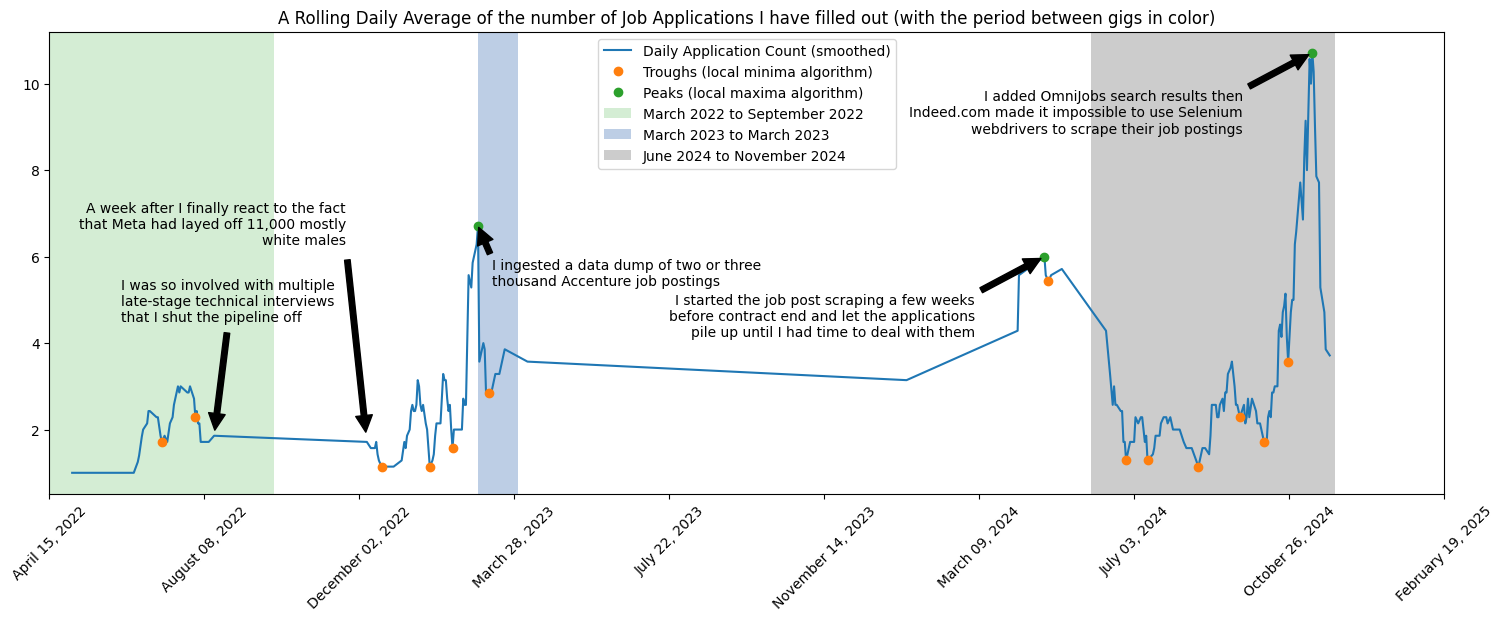

In [21]:

# Plot the data and the troughs
# fig_height = 18/nu.twitter_aspect_ratio
fig_width = 18; fig_height = 6
fig, ax = plt.subplots(figsize=(fig_width, fig_height))
ax.set_xlim(left=get_int_from_date(JOBS_DF.index.min()), right=get_int_from_date(JOBS_DF.index.max()))
ax.plot(int_dates_x, int_dates_y, label='Daily Application Count (smoothed)')
ax.plot(int_dates_x[trough_indices], int_dates_y[trough_indices], 'o', label='Troughs (local minima algorithm)')
ax.plot(int_dates_x[peak_indices], int_dates_y[peak_indices], 'o', label='Peaks (local maxima algorithm)')

if int_dates_x.min() < 1_719_201_600:
    title_str = 'A Rolling Daily Average of the number of Job Applications I have filled out (with the period between gigs in color)'
    
    # Mark the periods of unemployment
    for date_range_str, face_color_dict in zip(periods_list[1:], cycle_fn()):
        face_color = face_color_dict['color']
        date_range_list = date_range_str.split(' to ')
        first_day, last_day = get_vspan_days(date_range_list)
        ax.axvspan(get_int_from_date(first_day), get_int_from_date(last_day), facecolor=face_color, alpha=0.33, label=date_range_str)
    ax.legend()
    
    # Annotate layoff notes
    wrapper.width = 35
    ax.annotate('\n'.join(wrapper.wrap(interviews_text)), xy=interviews_xy, xycoords='data', xytext=interviews_xytext, textcoords='offset points',
                arrowprops=dict(facecolor='black', shrink=0.05), ha='center', va='bottom', ma='left')
    wrapper.width = 40
    ax.annotate('\n'.join(wrapper.wrap(meta_text)), xy=meta_xy, xycoords='data', xytext=meta_xytext, textcoords='offset points',
                arrowprops=dict(facecolor='black', shrink=0.05), ha='right', va='bottom')
    wrapper.width = 45
    ax.annotate('\n'.join(wrapper.wrap(accenture_text)), xy=accenture_xy, xycoords='data', xytext=accenture_xytext, textcoords='offset points',
                arrowprops=dict(facecolor='black', shrink=0.05), ha='left', va='bottom')
    ax.annotate('\n'.join(wrapper.wrap(bigbear_text)), xy=bigbear_xy, xycoords='data', xytext=bigbear_xytext, textcoords='offset points',
                arrowprops=dict(facecolor='black', shrink=0.05), ha='right', va='bottom')
    ax.annotate('\n'.join(wrapper.wrap(indeed_text)), xy=indeed_xy, xycoords='data', xytext=indeed_xytext, textcoords='offset points',
                arrowprops=dict(facecolor='black', shrink=0.05), ha='right', va='bottom')

else:
    title_str = 'A Rolling Daily Average of the number of Job Applications I have filled out'
ax.set_title(title_str)

# Reconfigure the x axis labels so that they are dates again
xtick_positions = ax.get_xticks(minor=False)
xtick_labels = [Text(ts, 0, datetime.fromtimestamp(ts).strftime(DATE_FORMAT)) for ts in xtick_positions]
XTick_obj = ax.set_xticks(xtick_positions, xtick_labels, rotation=45)


---
# Visualize Interview Progress

In [2]:

cypher_str = '''
    // Find all FileNames nodes in the graph with progress dates
    MATCH (fn:FileNames)
    
    // Count job hunting activity since last day of work
    WHERE ((fn.opportunity_application_email_date <= date()) AND (fn.opportunity_application_email_date >= date("2024-06-13")))
    
    // Return the progress dates, including the last technical interview date
    RETURN
        fn.opportunity_application_email_date AS opportunity_application_email_date,
        fn.recruiter_screen_date AS recruiter_screen_date,
        fn.technical_interview_dates[-1] AS technical_interview_date,
        fn.rejection_email_date AS rejection_email_date,
        fn.percent_fit AS percent_fit
    
    // Sort the results by successive progress dates
    ORDER BY
        fn.opportunity_application_email_date,
        fn.recruiter_screen_date,
        fn.technical_interview_dates[-1],
        fn.rejection_email_date;'''
row_objs_list = []
with cu.driver.session() as session:
    row_objs_list = session.write_transaction(cu.do_cypher_tx, cypher_str)
if row_objs_list:
    progress_dates_df = DataFrame(row_objs_list)

In [3]:

progress_dates_df

,opportunity_application_email_date,recruiter_screen_date,technical_interview_date,rejection_email_date,percent_fit
0,2024-06-15,None,None,2024-06-16,0.928571
1,2024-06-15,None,None,2024-06-17,0.857143
2,2024-06-15,None,None,2024-06-19,0.833333
3,2024-06-15,None,None,None,0.800000
4,2024-06-15,None,None,None,1.000000
...,...,...,...,...,...
162,2024-10-14,None,None,None,0.900000
163,2024-10-14,None,None,None,0.933333
164,2024-10-14,None,None,None,1.000000
165,2024-10-14,None,None,None,1.000000



---
# Visualize Daily Application Count

In [5]:

import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter, date2num

# Create a function to check if a value is in an interval
def value_in_interval(value, interval):
    return interval.left <= value < interval.right

# Create a new dataframe with a column for each interval
plot_df = email_dates_df[['email_date', 'percent_fit']].copy()
for i, interval in enumerate(intervals_list):
    plot_df[f'interval{i}'] = plot_df['percent_fit'].apply(lambda x: value_in_interval(x, interval))

# Group by week (starting on Sunday) and calculate the percentage of applications in each interval
plot_df['week_start'] = plot_df['email_date'] - pd.to_timedelta(plot_df['email_date'].dt.dayofweek, unit='D')
plot_df = plot_df.groupby('week_start').agg({f'interval{i}': 'mean' for i in range(len(intervals_list))})

# Make the last column 100 minus the sum of the other columns
# TODO: Check to see if this is right
column_name = f'interval{len(intervals_list)-1}'
other_columns = [f'interval{i}' for i in range(len(intervals_list)-1)]
plot_df[column_name] = 1.0 - plot_df[other_columns].sum(axis='columns')

# Convert datetime to matplotlib date numbers
dates_num = date2num(plot_df.index)

display(plot_df.head())

,interval0,interval1,interval2
week_start,,,
2022-05-02,0.0,0.000000,1.000000
2022-06-06,0.0,0.000000,1.000000
2022-06-13,0.0,0.000000,1.000000
2022-06-20,0.0,0.090909,0.909091
2022-06-27,0.0,0.000000,1.000000


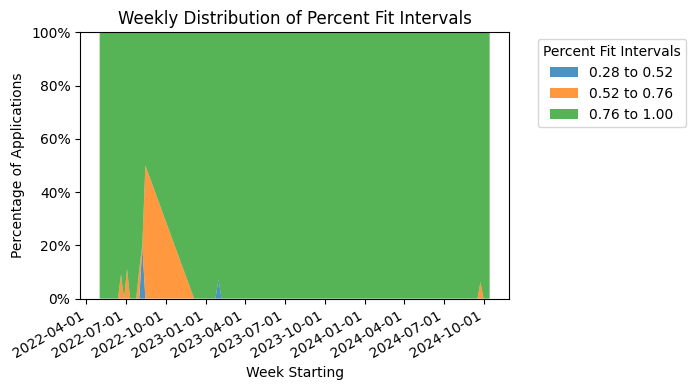

In [6]:

# Create the stacked area chart
fig, ax = plt.subplots(figsize=(4*nu.twitter_aspect_ratio, 4))

# Prepare data for stacking
y = plot_df.values.T * 100  # Transpose and convert to percentages
labels = [f'{interval.left:.2f} to {interval.right:.2f}' for interval in intervals_list]

# Plot stacked area chart
ax.stackplot(dates_num, y, labels=labels, alpha=0.8)

ax.set_xlabel('Week Starting')
ax.set_ylabel('Percentage of Applications')
ax.set_title('Weekly Distribution of Percent Fit Intervals')
ax.legend(title='Percent Fit Intervals', bbox_to_anchor=(1.05, 1), loc='upper left')

# Format x-axis to show dates nicely
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
fig.autofmt_xdate()  # Rotate and align the tick labels

# Ensure y-axis goes from 0 to 100%
ax.set_ylim(0, 100)

# Add percentage labels on y-axis
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"{x:.0f}%"))

plt.tight_layout()

# Show the plot
plt.show()

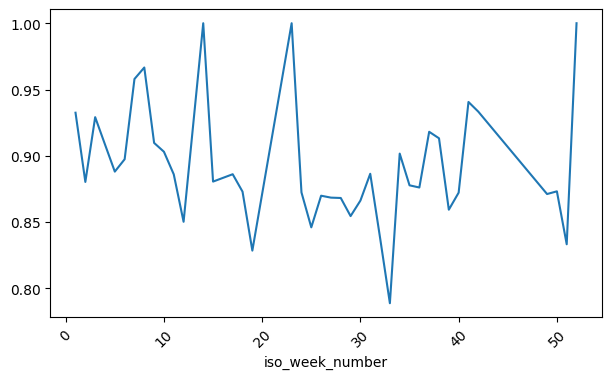

In [7]:

# Create a line chart of how closely the job description matches my qualifications by week number
fig, ax = plt.subplots(figsize=(4*nu.twitter_aspect_ratio, 4))
email_dates_df.groupby('iso_week_number').percent_fit.mean().plot(kind='line', rot=45,ax=ax);

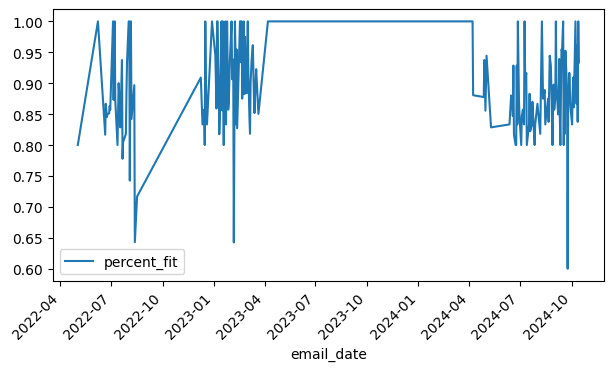

In [8]:

# Create a line chart of how closely the job description matches my qualifications by email date
df = email_dates_df.groupby('email_date').mean().drop(columns=['iso_week_number'])
fig, ax = plt.subplots(figsize=(4*nu.twitter_aspect_ratio, 4))
df.plot(kind='line', rot=45,ax=ax);

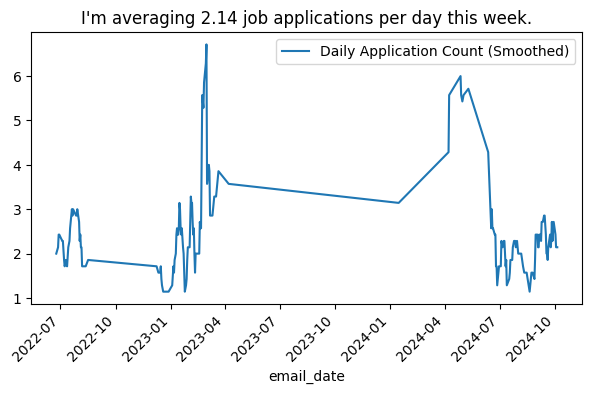

In [15]:

df = email_dates_df.groupby('email_date').count().rename(columns={'percent_fit': 'Daily Application Count (Smoothed)'}).rolling(7).mean().drop(columns=['iso_week_number'])
fig, ax = plt.subplots(figsize=(4*nu.twitter_aspect_ratio, 4))
ax.set_title(f"I'm averaging {df.iloc[-1]['Daily Application Count (Smoothed)']:.3} job applications per day this week.")
df.plot(kind='line', rot=45, ax=ax);


----
# Is it bad to get laid off in Spring?

In [7]:

# Study if it's bad to get laid off in Spring
import re

def get_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    elif month in [9, 10, 11]:
        return "Fall"
work_dates_list = [
    'March 2023 to June 2024', 'September 2022 to March 2023', 'May 2021 to March 2022', 'December 2020 to May 2021', 'January 2015 to October 2020'
]
date_format = '%B %Y'
rows_list = []
for work_date in work_dates_list:
    date_strs_list = work_date.split(' to ')
    start_date_obj = datetime.strptime(date_strs_list[0], date_format).date()
    end_date_obj = datetime.strptime(date_strs_list[1], date_format).date()
    end_season = get_season(end_date_obj.month)
    row_dict = {'start_date': start_date_obj, 'end_date': end_date_obj, 'end_season': end_season}
    rows_list.append(row_dict)
work_dates_df = DataFrame(rows_list).sort_values(['end_date'])

# Calculate the timedelta between the previous row's end date and current row's start date
work_dates_df['gap_days'] = (work_dates_df['start_date'] - work_dates_df['end_date'].shift(1)).map(lambda x: int(re.split(r'\D', str(x), 0)[0]), na_action='ignore')

In [8]:

work_dates_df

,start_date,end_date,end_season,gap_days
4,2015-01-01,2020-10-01,Fall,NaN
3,2020-12-01,2021-05-01,Spring,61.0
2,2021-05-01,2022-03-01,Spring,0.0
1,2022-09-01,2023-03-01,Spring,184.0
0,2023-03-01,2024-06-01,Summer,0.0


In [9]:

import pandas as pd
import numpy as np
from scipy import stats

# Convert gap_days to numeric, dropping NaN values
work_dates_df['gap_days'] = pd.to_numeric(work_dates_df['gap_days'], errors='coerce')
work_dates_df = work_dates_df.dropna(subset=['gap_days'])

# Split data into Spring and non-Spring groups
spring_gaps = work_dates_df[work_dates_df['end_season'] == 'Spring']['gap_days']
non_spring_gaps = work_dates_df[work_dates_df['end_season'] != 'Spring']['gap_days']

# Perform Mann-Whitney U test
statistic, p_value = stats.mannwhitneyu(spring_gaps, non_spring_gaps, alternative='two-sided')

print(f"Mann-Whitney U test results:")
print(f"Statistic: {statistic}")
print(f"p-value: {p_value}")

# Calculate and print median gap days for each group
print(f"\nMedian gap days for Spring: {spring_gaps.median()}")
print(f"Median gap days for non-Spring: {non_spring_gaps.median()}")

# Print sample sizes
print(f"\nSample size for Spring: {len(spring_gaps)}")
print(f"Sample size for non-Spring: {len(non_spring_gaps)}")

Mann-Whitney U test results:
Statistic: 2.5
p-value: 0.6373518882339371

Median gap days for Spring: 61.0
Median gap days for non-Spring: 0.0

Sample size for Spring: 3
Sample size for non-Spring: 1



Let's interpret these results step by step:

1. Mann-Whitney U test:
   - The test statistic is 2.5.
   - The p-value is approximately 0.637.

2. Median gap days:
   - For Spring: 61.0 days
   - For non-Spring: 0.0 days

3. Sample sizes:
   - Spring: 3 samples
   - Non-Spring: 1 sample

Interpretation:

1. Statistical Significance:
   The p-value (0.637) is much larger than the typical significance level of 0.05. This means we fail to reject the null hypothesis. In other words, based on this test, we cannot conclude that there's a statistically significant difference in gap days between Spring and non-Spring seasons.

2. Practical Difference:
   Despite the lack of statistical significance, we do see a practical difference in the median gap days. Spring has a median of 61 days, while non-Spring has 0 days. This suggests that in this small sample, there tend to be longer gaps after Spring endings.

3. Sample Size:
   The sample sizes are extremely small, especially for the non-Spring group (only 1 sample). This severely limits the reliability and power of the statistical test. With such small samples, it's very difficult to detect true differences even if they exist.

4. Limitations:
   - The extremely small sample size makes any conclusions highly unreliable.
   - The non-Spring group has only one sample, which is not enough to represent other seasons adequately.
   - The Mann-Whitney U test assumes the samples are independent, which may not be true for sequential job periods from the same person.

5. Practical Implications:
   While the data suggests longer gaps after Spring job endings, the small sample size and lack of statistical significance mean we cannot draw any reliable conclusions about whether it's "bad to get laid off in Spring" based on this data alone.

Recommendations:
1. Collect more data: A larger dataset would provide more reliable results.
2. Balance the samples: Try to get more data for non-Spring job endings.
3. Consider other factors: Look into other variables that might affect gap lengths between jobs.
4. Use this as a preliminary study: These results can guide further, more comprehensive research, but shouldn't be used for definitive conclusions.

In summary, while there's a hint that Spring job endings might lead to longer gaps, the extremely small sample size and lack of statistical significance mean we can't draw any firm conclusions from this data. More comprehensive data collection and analysis would be needed to reliably answer the question of whether it's worse to be laid off in Spring.


----

In [ ]:

# Define the nodes of the Sankey diagram
mask_series = progress_dates_df.recruiter_screen_date.isnull()
start_date = progress_dates_df[~mask_series].opportunity_application_email_date.min()
mask_series = (progress_dates_df.opportunity_application_email_date >= start_date)
df = progress_dates_df[mask_series]

labels_list = ['Applied', 'Recruiter Screen', 'Technical Interview', 'Rejected']
title_str = 'Interview Progress Sankey Diagram'
fig = go.Figure(data=[go.Sankey(
    arrangement='fixed',
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color='black', width=0.5),
        label=labels_list,
        y=[
            
            # Applied (node 0)
            0.0,

            # Recruiter Screen (node 1)
            0.333,

            # Technical Interview (node 2)
            0.667,

            # Rejected (node 3)
            1.0,
        
        ],
    ),
    link=dict(
        source=[
            
            # Link from Applied (node 0) to Recruiter Screen (node 1)
            labels_list.index('Applied'),

            # Link from Applied (node 0) to Rejected (node 3)
            labels_list.index('Applied'),

            # Link from Recruiter Screen (node 1) to Technical Interview (node 2)
            labels_list.index('Recruiter Screen'),

            # Link from Recruiter Screen (node 1) to Rejected (node 3)
            labels_list.index('Recruiter Screen'),

            # Link from Technical Interview (node 2) to Rejected (node 3)
            labels_list.index('Technical Interview'),
            
        ],
        target=[
            
            # Link from Applied (node 0) to Recruiter Screen (node 1)
            labels_list.index('Recruiter Screen'),

            # Link from Applied (node 0) to Rejected (node 3)
            labels_list.index('Rejected'),

            # Link from Recruiter Screen (node 1) to Technical Interview (node 2)
            labels_list.index('Technical Interview'),

            # Link from Recruiter Screen (node 1) to Rejected (node 3)
            labels_list.index('Rejected'),

            # Link from Technical Interview (node 2) to Rejected (node 3)
            labels_list.index('Rejected'),
            
        ],
        value=[
            
            # Applied to Recruiter Screen flow
            df[~df.opportunity_application_email_date.isnull() & ~df.recruiter_screen_date.isnull()].shape[0],

            # Applied to Rejected flow
            df[~df.opportunity_application_email_date.isna()&df.recruiter_screen_date.isna()&df.technical_interview_date.isnull()&~df.rejection_email_date.isna()].shape[0],

            # Recruiter Screen to Technical Interview flow
            df[~df.recruiter_screen_date.isnull() & ~df.technical_interview_date.isnull()].shape[0],

            # Recruiter Screen to Rejected flow
            df[~df.recruiter_screen_date.isnull() & df.technical_interview_date.isnull() & ~df.rejection_email_date.isnull()].shape[0],

            # Technical Interview to Rejected flow
            df[~df.technical_interview_date.isnull() & ~df.rejection_email_date.isnull()].shape[0],
            
        ]
    )
)])

fig.update_layout(title_text=title_str)
fig.show()


---
# Visualize Accenture Job Titles

In [17]:

# Get a set of all FileNames nodes properties
def do_cypher_tx(tx, verbose=False):
    cypher_str = """
        // Get all unique properties across all FileNames nodes
        MATCH (fn:FileNames)
        WITH collect(keys(fn)) AS all_properties
        WITH apoc.coll.toSet(apoc.coll.flatten(all_properties)) AS unique_properties
        RETURN unique_properties;"""
    if verbose:
        clear_output(wait=True)
        print(cypher_str)
    parameter_dict = {}
    Result_obj = tx.run(query=cypher_str, parameters=parameter_dict)
    properties_list = Result_obj.values()[0][0]
    properties_set = set(properties_list)

    return properties_set
with cu.driver.session() as session:
    properties_set = session.write_transaction(do_cypher_tx, verbose=False)
    print(properties_set)

{'is_opportunity_application_emailed', 'is_role_sold', 'role_title', 'recruiter_name', 'file_name_id', 'is_technical_interview_set', 'role_end_date', 'role_primary_contact', 'recruiter_email', 'role_client_supply_contact', 'posting_url', 'role_primary_contact_email_id', 'assigned_role', 'file_name', 'job_requisition_number', 'role_id', 'percent_fit', 'rejection_email_date', 'recruiter_screen_completion_date', 'client_name', 'role_start_date', 'is_verified', 'is_recruiter_screen_set', 'is_closed', 'indeed_status', 'is_recruiter_screen_completed', 'is_remote', 'is_tech_interview_completed', 'career_level_from_to', 'technical_interview_dates', 'opportunity_application_email_date', 'project_metro_city', 'rejection_email_text', 'rtr_name'}


In [40]:

def do_cypher_tx(tx, verbose=False):
    cypher_str = """
        // Get all the information related to job titles
        MATCH (fn:FileNames)
        WHERE (fn.role_title IS NOT NULL)
        RETURN fn;"""
    if verbose:
        clear_output(wait=True)
        print(cypher_str)
    parameter_dict = {}
    rows_list = []
    for record in tx.run(query=cypher_str, parameters=parameter_dict):
        row_dict = {k: v for k, v in dict(record.items())['fn'].items()}
        rows_list.append(row_dict)
    df = DataFrame(rows_list)

    return df
with cu.driver.session() as session:
    df = session.write_transaction(do_cypher_tx, verbose=False)
    # print(df.to_dict('records'))

['Data Scientist', 'Super Pod QA Lead', 'Data Designer', 'Data Engineer', 'Splunk Data Engineering PM', 'Splunk Developer', 'Splunk Senior Developer', 'Full Stack Developer']


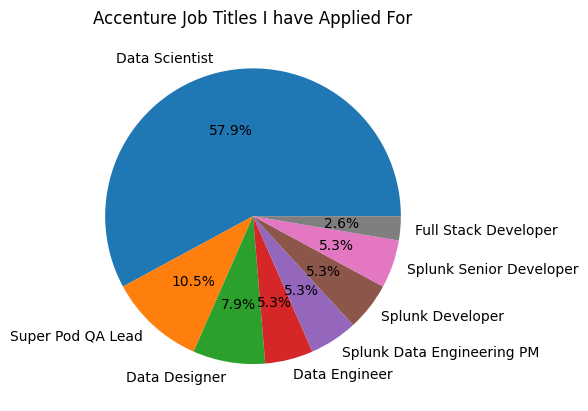

In [41]:

import re

df['job_title'] = df.role_title.map(lambda x: re.sub(r' Copy\b', '', re.sub(r'[0-9\-_]+', ' ', str(x)).split('(')[0]).strip())
mask_series = (df.percent_fit >= 0.8)
job_series = df[mask_series].groupby('job_title').count().sort_values('percent_fit', ascending=False).percent_fit
print(job_series.head(10).index.tolist())

# Create a pie chart
plt.pie(job_series.values, labels=job_series.index, autopct='%1.1f%%')
plt.title('Accenture Job Titles I have Applied For')

# Display the chart
plt.show()

In [42]:

df.columns

Index(['assigned_role', 'career_level_from_to', 'file_name',
       'role_primary_contact_email_id', 'is_role_sold', 'role_title',
       'role_client_supply_contact', 'is_opportunity_application_emailed',
       'opportunity_application_email_date', 'role_id', 'project_metro_city',
       'role_end_date', 'percent_fit', 'role_primary_contact',
       'role_start_date', 'client_name', 'is_verified', 'rejection_email_text',
       'is_closed', 'rejection_email_date', 'job_title'],
      dtype='object')

In [43]:

mask_series = df.job_title.map(lambda x: 'Data Scientist' in x)
columns_list = ['percent_fit', 'assigned_role', 'role_title', 'opportunity_application_email_date', 'file_name']
df[mask_series][columns_list].sort_values('percent_fit')

,percent_fit,assigned_role,role_title,opportunity_application_email_date,file_name
0,1.0,Business Analyst,62812-439276_Data Scientist(priya.raman),2023-02-22,4656042_Accenture_CIO_62812_439276_Data_Scient...
34,1.0,Business Analyst,62812-439275_Data Scientist(priya.raman),2023-02-22,4656041_0_Accenture_CIO_62812_439275_Data_Scie...
33,1.0,Business Analyst,62812-439274_Data Scientist(priya.raman),2023-02-22,4656040_0_Accenture_CIO_62812_439274_Data_Scie...
32,1.0,Business Analyst,62812-439271_Data Scientist(priya.raman),2023-02-22,4656039_0_Accenture_CIO_62812_439271_Data_Scie...
31,1.0,Business Analyst,62812-439416_Data Scientist(priya.raman),2023-02-22,4656014_0_Accenture_CIO_62812_439416_Data_Scie...
30,1.0,Business Analyst,62812-439415_Data Scientist(priya.raman),2023-02-22,4656013_0_Accenture_CIO_62812_439415_Data_Scie...
29,1.0,Business Analyst,62812-439414_Data Scientist(priya.raman),2023-02-22,4656012_0_Accenture_CIO_62812_439414_Data_Scie...
28,1.0,Business Analyst,62812-439413_Data Scientist(priya.raman),2023-02-25,4656011_0_Accenture_CIO_62812_439413_Data_Scie...
27,1.0,Business Analyst,62812-439401_Data Scientist(priya.raman),2023-02-22,4656010_0_Accenture_CIO_62812_439401_Data_Scie...
26,1.0,Business Analyst,62812-439400_Data Scientist(priya.raman),2023-02-22,4656009_0_Accenture_CIO_62812_439400_Data_Scie...



----